In [3]:
import jax, jax.numpy as jnp, jax.random as jr
jax.config.update("jax_enable_x64", True)
import numpy as np, sys, os, time
import matplotlib.pyplot as plt
from functools import partial
import tqdm.auto as tqdm
import itertools
na = jnp.newaxis

sys.path.insert(0, '../../../22_3_1_DLC_MOSEQ/keypointMoSeq/')
from keypoint_moseq.util import *
from keypoint_moseq.gibbs import *
from keypoint_moseq.initialize import *

In [4]:
latent_dim = 6           # dimension of latent trajectories
num_states = 20         # max number of states
nlags = 3                # number of lags for AR dynamics

keypoint_dim = 2   # embedding dimension of keypoints
num_keypoints = 9  # number of keypoints

trans_hypparams = {
    'gamma': 1e3, 
    'alpha': 100, 
    'kappa': 5e7,
    'num_states':num_states}

ar_hypparams = {
    'nu_0': latent_dim+2,
    'S_0': 10*jnp.eye(latent_dim),
    'M_0': jnp.pad(jnp.eye(latent_dim),((0,0),((nlags-1)*latent_dim,1))),
    'K_0': 0.01*jnp.eye(latent_dim*nlags+1),
    'num_states':num_states,
    'nlags':nlags}

obs_hypparams = {
    'sigmasq_0': 5,
    'sigmasq_C': 1,
    's_0': 1}

translation_hypparams = {
    'sigmasq_loc': 1
}

hypparams = {
    'latent_dim' : 6,
    'trans_hypparams' : trans_hypparams,
    'ar_hypparams' : ar_hypparams,
    'obs_hypparams' : obs_hypparams,
    'translation_hypparams' : translation_hypparams,
    'inlier_variance' : 1,
    'outlier_variance' : 1e6,
    'keypoint_dx_variance' : 5,
    'anterior_keypoints' : [6,7,8],
    'posterior_keypoints' : [1,2,3]
}

In [88]:
def npad(X, n, axis):
    return [(0,0) if i != axis else (0,n-X.shape[axis]) for i in range(len(X.shape))]

In [89]:
import os, joblib

cam_ix = 1
camera = 'bottom'
data_dir = '../../22_2_6_opto_attack_with_PFC_recordings_v2/'
segments = joblib.load('../../22_2_6_opto_attack_with_PFC_recordings_v2/segments.p')
parents = jnp.array([2, 2, 5, 5, 5, 5, 5, 5, 5])

Ys,As,Is,names = [],[],[],[]
for prefix,segs in tqdm.tqdm(segments.items()):
    Y = np.transpose(np.load(data_dir+prefix+'.bottom.Y.npy'), axes=(2,0,1,3))
    I = np.transpose(np.load(data_dir+prefix+'.bottom.I.npy'), axes=(2,3,0,1))
    A = np.transpose(np.load(data_dir+prefix+'.bottom.A.npy'), axes=(2,3,0,1))
    for i,(s,e) in enumerate(segs):
        names.append((data_dir+prefix,s,e))
        e = s+5000
        Ys.append(Y[:,s:e,:,na,:])
        Is.append(I[:,:,s:e,:,na])
        As.append(A[:,:,s:e,:,na])
    if len(names)>20: break
        


max_length = np.max([Y.shape[1] for Y in Ys])
observations = jnp.array([np.pad(Y, npad(Y,max_length,1)) for Y in Ys], dtype=jnp.float64)
identity = jnp.array([np.pad(I, npad(I,max_length,2)) for I in Is], dtype=jnp.float64)
II = np.array(identity)
affinity = jnp.array([np.pad(A, npad(A,max_length,2)) for A in As], dtype=jnp.float64)
affinity = jax.nn.log_sigmoid((affinity-0.1)*50)
affinity -= ((observations[:,:,na,:,:]-observations[:,na,:,:,parents])**2).sum(-1) / 50**2
affinity = affinity - jax.nn.logsumexp(affinity,axis=2, keepdims=True)

mask = jnp.array([np.pad(np.ones(Y.shape[1]), (0,max_length-Y.shape[1])) for Y in Ys], dtype=jnp.float64)
outlier_probs = jnp.clip(jax.nn.sigmoid((.5-identity.max(2))*20),1e-6,1-1e-6)

identity = jax.nn.log_sigmoid((identity-0.5)*5)
identity = identity - jax.nn.logsumexp(identity,axis=2, keepdims=True)



 35%|███▌      | 18/51 [00:00<00:01, 18.60it/s]


In [90]:
def isotropic_gaussian_log_prob(y, mu, sigmasq):
    diff = ((y-mu)**2).sum(-1)
    return -diff/2/sigmasq -jnp.log(sigmasq)/2*y.shape[-1] 


def simple_kalman_filter(ys, mask, rs, m0, s0, q):
    
    def _step(carry, args):
        ll, m_pred, s_pred, r, y = *carry, *args
        ll += isotropic_gaussian_log_prob(y, m_pred, s_pred + r)
        s_cond = 1/(1/s_pred + 1/r)
        m_cond = s_cond*(m_pred/s_pred + y/r)
        return (ll, m_cond, s_cond + q), (m_cond, s_cond)
    
    def _masked_step(carry, args):
        return carry, carry[1:]

    (ll, _, _), (filtered_ms, filtered_ss) = jax.lax.scan(
        lambda carry,args: jax.lax.cond(
            args[0]>0, _step, _masked_step, carry, args[1:]),
        (0., m0, s0), (mask, rs, ys))
    return ll, filtered_ms, filtered_ss


def simple_kalman_sample(key, ys, mask, rs, m0, s0, q):
    
    def _step(xn, args):
        weight, sample = args
        x = weight*xn + sample
        return x, x
    
    def _masked_step(x, args):
        return x,jnp.zeros_like(x)

    
    ll, filtered_ms, filtered_ss = simple_kalman_filter(ys, mask, rs, m0, s0, q)
    s_conds = 1/(1/filtered_ss + 1/q)
    samples = jr.normal(key, filtered_ms.shape) * jnp.sqrt(s_conds)[:,na]
    samples += (s_conds/filtered_ss)[:,na] * filtered_ms
    xT = jr.normal(key, filtered_ms[-1].shape)
    xT = xT*jnp.sqrt(filtered_ss[-1]) + filtered_ms[-1]
    
    args = (mask[:-1], (s_conds/q)[:-1], samples[:-1])
    _, xs = jax.lax.scan(lambda carry,args: jax.lax.cond(
        args[0]>0, _step, _masked_step, carry, args[1:]), xT, args, reverse=True)
    return jnp.vstack([xs, xT])


@jax.jit
def sample_positions(key, obs, mask, outliers, hypparams):
    keys = jr.split(key, obs.shape[-2])
    q = hypparams['keypoint_dx_variance']
    rs = (hypparams['outlier_variance']*outliers
         +hypparams['inlier_variance']*(1-outliers)).astype(float)
    resample_one = jax.vmap(simple_kalman_sample, in_axes=(0,-2,na,-1,-2,na,na), out_axes=-2)
    resample_all = jax.vmap(resample_one,  in_axes=(na,0,0,0,0,na,na), out_axes=0)
    return resample_all(keys, obs, mask, rs, obs[:,0], 1., q)

@jax.jit
def sample_outliers(key, obs, positions, outlier_prob, hypparams):
    outlier_lp = observations_log_prob(obs, positions, hypparams['outlier_variance'])
    inlier_lp = observations_log_prob(obs, positions, hypparams['inlier_variance'])
    prob = jnp.exp(outlier_lp - jnp.logaddexp(outlier_lp,inlier_lp)) * outlier_prob
    return jr.bernoulli(key, prob)
   
@jax.jit
def observations_log_prob(obs, positions, variance):
    sqdev = ((obs-positions)**2).sum(-1)
    norm = jnp.log(variance)/2*obs.shape[-1]
    return -sqdev/2/variance-norm
    
def eliminate_camera_axis(obs, outlier_prob):
    return obs[...,0,:],outlier_prob[...,0]
    
    
    

class KeypointSLDS:
    def __init__(self, hypparams, params=None):
        self.key = jr.PRNGKey(0)
        self.hypparams = hypparams
        if params is None: self.params = {}
        else: self.params = params
        self.states = {}
        self.positions = None
    
    def initialize(self, obs, outlier_prob, mask):
        obs,outlier_prob = eliminate_camera_axis(obs,outlier_prob)
        self.key, *keys = jr.split(self.key, 6)
        data = {'Y':obs, 'mask':mask}
    
        # initialize outliers
        self.outliers = jr.bernoulli(keys[0], outlier_prob)
        
        # initialize centroid/heading
        self.states['v'] = v = initial_location(
            **data, **self.states, outliers=self.outliers)

        self.states['h'] = h = initial_heading(
            **data, **self.states, **self.hypparams, outliers=self.outliers)
        
        # initialize latent states and obs params
        if not 'sigmasq' in self.params: 
            self.params['sigmasq'] = jnp.ones(data['Y'].shape[-2]) * \
                self.hypparams['obs_hypparams']['sigmasq_0']

        self.states['s'] = jnp.ones(obs.shape[:-1]) * \
            self.hypparams['obs_hypparams']['s_0']

        if not 'Cd' in self.params:
            self.states['x'],self.params['Cd'] = initial_latents(
                keys[1], latent_dim=self.hypparams['latent_dim'], 
                **data, **self.states, outliers=self.outliers)
        else: 
            Cd,Gamma = self.params['Cd'], center_embedding(data['Y'].shape[-2])
            ys = inverse_affine_transform(data['Y'],v,h).reshape(*data['Y'].shape[:-2],-1)
            self.states['x'] = (ys@jnp.kron(Gamma, jnp.eye(2)) - Cd[:,-1]) @ Cd[:,:-1]

        # initialize positions
        self.positions = sample_positions(keys[2], obs, mask, self.outliers, self.hypparams)

        # initialize AR params and stateseq
        if not 'pi' in self.params: self.params['betas'],self.params['pi'] = \
            initial_hdp_transitions(keys[3], **self.hypparams['trans_hypparams'])
        if not 'Ab' in self.params: self.params['Ab'],self.params['Q'] = \
            initial_ar_params(keys[4], **self.hypparams['ar_hypparams'])
        self.states['z'] = resample_stateseqs(keys[4], **data, **self.states, **self.params)

    
    def resample_states(self, data):
        self.key, *keys = jr.split(self.key, 5)

        self.states['z'] = resample_stateseqs(
            keys[0], **data, **self.states, **self.params)

        self.states['x'] = resample_latents(
            keys[1], **data, **self.states, **self.params)

        self.states['h'] = resample_heading(
            keys[2], **data, **self.states, **self.params)

        self.states['v'] = resample_location(
            keys[3], **data, **self.states, **self.params, 
            **self.hypparams['translation_hypparams'])
        
    def resample_params(self, data):
        self.key, *keys = jr.split(self.key, 4)
        
        self.params['Ab'],self.params['Q'] = resample_ar_params(
            keys[0], **data, **self.states, **self.params, 
            **self.hypparams['ar_hypparams'])

        self.params['Cd'] = resample_obs_params(
            keys[1], **data, **self.states, **self.params, 
            **self.hypparams['obs_hypparams'])

        self.params['betas'],self.params['pi'] = resample_hdp_transitions(
            keys[2], **data, **self.states, **self.params, 
            **self.hypparams['trans_hypparams'])
        
        
    def step(self, obs, outlier_prob, mask, update_params=False):
        self.key, *keys = jr.split(self.key, 3)
        obs,outlier_prob = eliminate_camera_axis(obs,outlier_prob)

        self.outliers = sample_outliers(
            keys[0], obs, self.positions, outlier_prob, self.hypparams)

        self.positions = sample_positions(
            keys[1], obs, mask, self.outliers, self.hypparams)

        data = {'Y': self.positions, 'mask':mask}
        self.resample_states(data)
        if update_params: self.resample_params(data)



    def log_likelihood(self, obs, outlier_prob):
        obs,outlier_prob = eliminate_camera_axis(obs,outlier_prob)
        
        outlier_lp = observations_log_prob(
            obs, self.positions, self.hypparams['outlier_variance'])
        
        inlier_lp = observations_log_prob(
            obs, self.positions, self.hypparams['inlier_variance'])
        
        prior = jnp.stack([1-outlier_prob, outlier_prob])
        lp = jax.nn.logsumexp(jnp.stack([inlier_lp,outlier_lp]), b=prior, axis=0)
        return lp[...,na]

    


In [ ]:
class KeypointGMM:
    def __init__(self, hypparams, params=None):
        self.key = jr.PRNGKey(0)
        self.hypparams = hypparams
        if params is None: self.params = {}
        else: self.params = params
        self.states = {}
        self.positions = None
    
    def initialize(self, obs, outlier_prob, mask):
        obs,outlier_prob = eliminate_camera_axis(obs,outlier_prob)
        self.key, *keys = jr.split(self.key, 4)
        data = {'Y':obs, 'mask':mask}
    
        # initialize outliers
        self.outliers = jr.bernoulli(keys[0], outlier_prob)
        
        # initialize centroid/heading
        self.states['v'] = v = initial_location(
            **data, **self.states, outliers=self.outliers)

        self.states['h'] = h = initial_heading(
            **data, **self.states, **self.hypparams, outliers=self.outliers)
        
        if not 'mu' in self.params:
            self.params['mu'], self.params['Sigma'] = initial_cluster_params(
                **data, **self.states, **self.hypparams)

        self.states['z'] = resample_cluster_ixs(
            keys[1], **data, **self.states, **self.params)
        
        # initialize positions
        self.positions = sample_positions(
            keys[2], obs, mask, self.outliers, self.hypparams)

        
    def resample_states(self, data):
        self.key, *keys = jr.split(self.key, 3)

        self.states['z'] = resample_cluster_ixs(
            keys[0], **data, **self.states, **self.params)

        self.states['h'] = resample_heading(
            keys[1], **data, **self.states, **self.params)

        self.states['v'] = resample_location(
            keys[2], **data, **self.states, **self.params, 
            **self.hypparams['translation_hypparams'])
        
    def resample_params(self, data):
        self.key, *keys = jr.split(self.key, 4)
        
        self.params['mu'],self.params['Sigma'] = resample_cluster_params(
            keys[0], **data, **self.states, **self.params)

        self.params['Cd'] = resample_obs_params(
            keys[1], **data, **self.states, **self.params, 
            **self.hypparams['obs_hypparams'])

        self.params['betas'],self.params['pi'] = resample_hdp_transitions(
            keys[2], **data, **self.states, **self.params, 
            **self.hypparams['trans_hypparams'])
        
        
    def step(self, obs, outlier_prob, mask, update_params=False):
        self.key, *keys = jr.split(self.key, 3)
        obs,outlier_prob = eliminate_camera_axis(obs,outlier_prob)

        self.outliers = sample_outliers(
            keys[0], obs, self.positions, outlier_prob, self.hypparams)

        self.positions = sample_positions(
            keys[1], obs, mask, self.outliers, self.hypparams)

        data = {'Y': self.positions, 'mask':mask}
        self.resample_states(data)
        if update_params: self.resample_params(data)



    def log_likelihood(self, obs, outlier_prob):
        obs,outlier_prob = eliminate_camera_axis(obs,outlier_prob)
        
        outlier_lp = observations_log_prob(
            obs, self.positions, self.hypparams['outlier_variance'])
        
        inlier_lp = observations_log_prob(
            obs, self.positions, self.hypparams['inlier_variance'])
        
        prior = jnp.stack([1-outlier_prob, outlier_prob])
        lp = jax.nn.logsumexp(jnp.stack([inlier_lp,outlier_lp]), b=prior, axis=0)
        return lp[...,na]


In [91]:
def viterbi_assignments(
    top_order, assign_lls,  
    clique_affinity_row_norm,
    clique_affinity_col_norm):
    """
    Compute max likelihood assignments for each keypoint observation
    given affinity scores and independent keypoint/assignment log-likelihoods.
    """
    # get subtree potentials by message passing up the tree
    N,T,K,C = assign_lls.shape[1:]
    permutations = all_permutations(N)
    clique_marg = normalize((assign_lls[permutations] * jnp.eye(N).reshape(1,N,N,1,1,1)).sum((1,2)))
    
    # get marginals going up the tree
    pass_backward = partial(
        tree_pass_backward, parents, 
        clique_affinity_col_norm)
    subtree_marg = jax.lax.scan(pass_backward, clique_marg, top_order[::-1])[0]

    # get ml assignments going down the tree
    pass_forward = partial(
        tree_max_likelihood_forward, parents,
        subtree_marg, clique_affinity_row_norm)
    samples = jax.lax.scan(pass_forward, jnp.zeros((T,K,C), dtype=int), top_order)[0]
    return jnp.transpose(permutations[samples], axes=(3,0,1,2))


@jax.jit
def initial_assignments(
    observations, identity, 
    clique_affinity_row_norm,
    clique_affinity_col_norm,
    top_order, eta):
    """
    To initialize assignments, first get maximum likelihood assignments
    for each frame separately using just affinities and identity probabilities,
    then use the continuity of keypoint locations to optionally permute
    the labels in each frame (eta = gaussian kernel variance for continuity).
    """
    N, T, K, C = observations.shape[:-1]
    permutations = all_permutations(N)

    assignments_init = viterbi_assignments(
        top_order, identity,
        clique_affinity_row_norm,
        clique_affinity_col_norm)

    # get permutation_lls[p,t,c] = log P (identity | permutation p (assignments_init[time t and camera c]))
    group_lls = split_animals(jnp.moveaxis(identity,1,-1), assignments_init).sum(2)
    permutations_lls = (group_lls[permutations] * jnp.eye(N).reshape(1,N,1,1,N)).sum((1,4))

    # tmats[c,t,:,:] = permutation->permutation transitions probs, based on 
    # random walk model with variance eta for keypoint motion across frames
    obs_split = split_animals(observations, assignments_init)
    permutation_transition_ll = -((obs_split[permutations,1:] - obs_split[na,:,:-1])**2).sum((1,3,5)) / eta
    perm2perm = jnp.argmax((permutations[:,permutations][:,:,na,:]==permutations[na,na:,:]).sum(-1),-1) 
    transition_lls = permutation_transition_ll[perm2perm,:,:]
    tmats = jnp.exp(transition_lls - transition_lls.max(1, keepdims=True))+1e-6
    log_tmats = jnp.log(jnp.transpose(tmats / tmats.sum(1, keepdims=True), axes=(3,2,0,1)))

    # apply simple hmm viterbi algo
    L = log_tmats + permutations_lls.T[:,1:,na,:]
    P0 = jnp.ones((C,L.shape[2]))/L.shape[2]
    seqs = jax.vmap(viterbi_simple)(L,P0)

    # apply permutations to ``assignments_init``
    assignments_init = jnp.take_along_axis(assignments_init, permutations[seqs].T.reshape(N,T,1,C), axis=0)
    return assignments_init



def viterbi_simple(L, P0):
    """Vanilla Viterbi algorithm where L[t,i,j] = log P( seq[t+1]=j | seq[t]=i )
    """
    def forward(trellis, L):
        P = trellis[:,na] + L
        trellis = P.max(0)
        pointer = jnp.argmax(P,axis=0)
        return trellis, pointer

    def back(i,pointer):
        return (pointer[i],pointer[i])
    trellis,pointers = jax.lax.scan(forward, P0, L)
    end_state = jnp.argmax(trellis,axis=0)
    seq = jax.lax.scan(back, end_state, pointers)[1]
    return jnp.append(seq, end_state)



def topological_sort(parents):
    """ Sort tree nodes such that parents precede children
    """
    parents = np.array(parents)
    to_go = np.ones(len(parents))>0
    topological_order = []
    while True:
        leaves = np.all([to_go,~np.in1d(np.arange(len(parents)),parents[to_go])],axis=0).nonzero()[0]
        if len(leaves)==0: break
        topological_order.append(leaves)
        to_go[leaves] = 0
    topological_order.append(to_go.nonzero()[0])
    return jnp.array(np.hstack(topological_order))[::-1]

    

def all_permutations(N):
    return jnp.array(list(itertools.permutations(range(N))))

def tree_pass_backward(parents, clique_affinity_col_norm, subtree_marg, k):
    msg = jax.nn.logsumexp(clique_affinity_col_norm[:,:,:,k,:]+subtree_marg[:,na,:,k,:],axis=0)
    return subtree_marg.at[:,:,parents[k],:].add(msg), None

def tree_samp_forward(parents, subtree_marg, clique_affinity_row_norm, carry, k):
    key, samples = carry
    key, newkey = jr.split(key)
    cond_k = jnp.take_along_axis(clique_affinity_row_norm[:,:,:,k], samples[:,parents[k]][na,na], axis=1)[:,0]
    marg_k = subtree_marg[:,:,k,:] + cond_k
    sample = jr.categorical(newkey, marg_k, axis=0)
    return (key, samples.at[:,k].set(sample)), None

def split_animals(X, assignments):
    """Use assignments to sort an array X of shape (B,N,T,K,C,...) such 
    that all keypoints for animal i are in slice [:,i,:,:,:,...]
    """
    extra_axes = len(X.shape)-len(assignments.shape)
    assignments = assignments.reshape(*assignments.shape, *[1]*extra_axes)
    return jnp.take_along_axis(X, assignments, axis=0)

@jax.jit
def forward_backward_assignments(
    key, parents, top_order, assign_lls, 
    clique_affinity_row_norm,
    clique_affinity_col_norm):
    """
    Sample posterior assignments for each keypoint observation
    given affinity scores and independent keypoint/assignment log-likelihoods.
    """
    # get subtree potentials by message passing up the tree
    N,T,K,C = assign_lls.shape[1:]
    permutations = all_permutations(N)
    clique_marg = normalize((assign_lls[permutations] * jnp.eye(N).reshape(1,N,N,1,1,1)).sum((1,2)))

    # get marginals going up the tree
    pass_backward = partial(
        tree_pass_backward, parents, 
        clique_affinity_col_norm)
    subtree_marg = jax.lax.scan(pass_backward, clique_marg, top_order[::-1])[0]
    
    # sample full posterior sample by sampling down the tree
    pass_forward = partial(
        tree_samp_forward, parents, 
        subtree_marg, clique_affinity_row_norm)
    samples = jax.lax.scan(pass_forward, (key, jnp.zeros((T,K,C),dtype=int)), top_order)[0][1]
    return jnp.transpose(permutations[samples], axes=(3,0,1,2))

def normalize(X, axis=0):
    return X - jax.nn.logsumexp(X, axis=axis, keepdims=True)


def tree_max_likelihood_forward(parents, subtree_marg, clique_affinity_row_norm, samples, k): 
    cond_k = clique_affinity_row_norm[:,samples[:,parents[k],:],
                                       jnp.arange(samples.shape[0])[:,na],k,
                                       jnp.arange(samples.shape[2])[na,:]]
    sample = jnp.argmax(subtree_marg[:,:,k,:] + cond_k, axis=0)
    return samples.at[:,k,:].set(sample), None
    #return jax.ops.index_update(samples, jax.ops.index[:,k,:], sample), None



class KeypointSort:
    """Implements the keypoint sorting model described in [paper].
    Given keypoint observations for multiple animals, the goal
    is to infer the animal-identity for each keypoint.
    
    Inference is based on part-affinity-field scores for the keypoints
    and on a kinematics model for each animal. The kinematics model
    is modular: any model can be used as long as it can produce
    a log-likelihood score for each keypoint observation. 
    
    Parameters
    ----------
    kinematics_models : list of objects (one per animal)
        Objects to use for kinematics modeling. 
    
    observations: ndarray, shape (B,N,T,K,C,dim_obs)
        Location of instance i of keypoint k for time t and camera c
        
    outlier_probs: ndarray, shape (B,N,T,K,C)
        Outlier probabilities based on neural net confidence

    affinity : ndarray, shape (B,N,N,T,K,C)
        Log probability that two keypoints observations belong to same animal.
        affinity[i,j,t,k,c] = log P(instance i of keypoint k is from the same
        animal as instance j of keypoint parent(k) for time t and camera c)

    identity : ndarray, shape (B,N,N,T,K,C)
        Log probability that each keypoint observation belongs to a specific
        animal. identity[i,j,t,k,c] = log P(instance i of keypoint k belongs
        to animal j for time t and camera c)

    assignments: ndarray, shape (B,N,T,K,C)
        The current animal assignment for each keypoint observation.
        assignment[i,t,k,c] = assignment of instance i of keypoint k
        for time t and camera c.  
        
    parents : ndarray, shape (K,)
        The parent of each joint. parent[i] = [parent of node i]. The root 
        node should be its own parent.
        
    top_order : ndarray, shape (K,)
        Topological ordering of joints (parents followed by children).
   
    permutations : ndarray, shape (N!,N)
        All permutations of size N
        
    """
    def __init__(self, parents,
                 kinematics_models, 
                 observations,
                 outlier_probs,
                 affinity, 
                 identity,
                 mask):

        
        self.kinematics_models = kinematics_models
        self.observations = observations
        self.outlier_probs = outlier_probs
        self.affinity = affinity
        self.identity = identity
        self.parents = parents
        self.mask = mask
        
        N,T,K,C = observations.shape[1:-1]
        
        
        # initialize params
        self.key = jax.random.PRNGKey(0)
        self.top_order = topological_sort(parents)
        self.permutations = all_permutations(N)
        self.clique_affinity = (affinity[:,self.permutations,:][:,:,self.permutations] 
                              * jnp.eye(N).reshape(1,1,N,1,N,1,1,1)).sum((2,4))
        
        self.clique_affinity_row_norm = normalize(self.clique_affinity, axis=2)
        self.clique_affinity_col_norm = normalize(self.clique_affinity, axis=1)
        
        

    def initialize(self, eta=10):
        """Initialize assignments using maximum likelihood inference over 
        affinities, initial identity probabilities and keypoint proximity,
        then use these assignments to initialize the kinematics models.
        """
        self.assignments = jax.vmap(
            initial_assignments, in_axes=(0,0,0,0,None,None))(
            self.observations, self.identity,
            self.clique_affinity_row_norm,
            self.clique_affinity_col_norm,
            self.top_order, eta)
        
        for model, obs, out_p in zip(self.kinematics_models,
            jnp.moveaxis(jax.vmap(split_animals)(
                self.observations,self.assignments),1,0),
            jnp.moveaxis(jax.vmap(split_animals)(
                self.outlier_probs,self.assignments),1,0)): 
            model.initialize(obs, out_p, self.mask)
        
    def step(self, update_params=False):
        """Perform one Gibbs step. Each step consists of resampling params in 
        each kinematics model (using the current assignments), and then resampling
        assignments using log probabilities from the kinematics models. 
        """
        assign_lls = [jax.vmap(
            model.log_likelihood, in_axes=1, out_axes=1)(
            self.observations, self.outlier_probs
        ) for model in self.kinematics_models]

        self.key, key = jr.split(self.key)
        self.assignments = jax.vmap(
            forward_backward_assignments, in_axes=(None,None,None,0,0,0))(
            key, self.parents, self.top_order,
            jnp.stack(assign_lls,axis=2)+self.identity,
            self.clique_affinity_row_norm,
            self.clique_affinity_col_norm)

        for model, obs, out_p in zip(self.kinematics_models,
            jnp.moveaxis(jax.vmap(split_animals)(
                self.observations,self.assignments),1,0),
            jnp.moveaxis(jax.vmap(split_animals)(
                self.outlier_probs,self.assignments),1,0)): 
            model.step(obs, out_p, self.mask, update_params=update_params)


In [92]:
models = [KeypointSLDS(hypparams),KeypointSLDS(hypparams)]
kps = KeypointSort(parents, models, observations, outlier_probs, affinity, identity, mask)


In [93]:
kps.initialize()

In [94]:
stability = []
assignments = []
outliers = []
positions = []
prev_assignments = kps.assignments
pbar = tqdm.trange(100)
for itr in pbar:
    kps.step(update_params=True)
    stability.append((kps.assignments==prev_assignments).mean())
    assignments.append(np.array(kps.assignments[0]))
    outliers.append([np.array(m.outliers[0]) for m in models])
    positions.append([np.array(m.positions[0]) for m in models])
    prev_assignments = kps.assignments
    pbar.set_description("stability={:.2f}".format(stability[-1]))
    


stability=1.00:  47%|████▋     | 47/100 [06:51<07:44,  8.76s/it]


KeyboardInterrupt: 

In [98]:
import imageio, cv2, tqdm

In [99]:
xys = np.moveaxis(np.array(observations[0,:,:,:,0,:]),0,1).reshape(-1,9*2,2)
pos = [np.array(m.positions[0]) for m in models]
assignments = np.moveaxis(np.array(kps.assignments[0,:,:,:,0]),0,1).reshape(-1,9*2)
prefix,s,e = names[0]
reader = imageio.get_reader(prefix+'.bottom.ir.mp4')
writer = imageio.get_writer('kps.mp4', pixelformat='yuv420p', fps=30, quality=8)
for ix in tqdm.trange(5000):
    im = reader.get_data(ix+s)
    for xy,a in zip(xys[ix],assignments[ix]):
        xy = (int(xy[0]),int(xy[1]))
        im = cv2.circle(im, xy, 3, [(0,0,255),(255,0,0)][a], -1, cv2.LINE_AA)
    for k in range(9):
        xy1 = pos[0][ix,k]
        xy2 = pos[1][ix,k]
        im = cv2.circle(im, (int(xy1[0]), int(xy1[1])), 5, (0,0,255), 1, cv2.LINE_AA)
        im = cv2.circle(im, (int(xy2[0]), int(xy2[1])), 5, (255,0,0), 1, cv2.LINE_AA)
    writer.append_data(im)
writer.close()

100%|██████████| 5000/5000 [00:12<00:00, 388.53it/s]


In [103]:
ix = 21505-s

In [104]:
m = 1
gamma = center_embedding(9)
yy = gamma @ (models[m].params['Cd'] @ pad_affine(models[m].states['x'][0,ix])).reshape(8,2)
yy = affine_transform(yy, models[m].states['v'][0,ix],models[m].states['h'][0,ix])

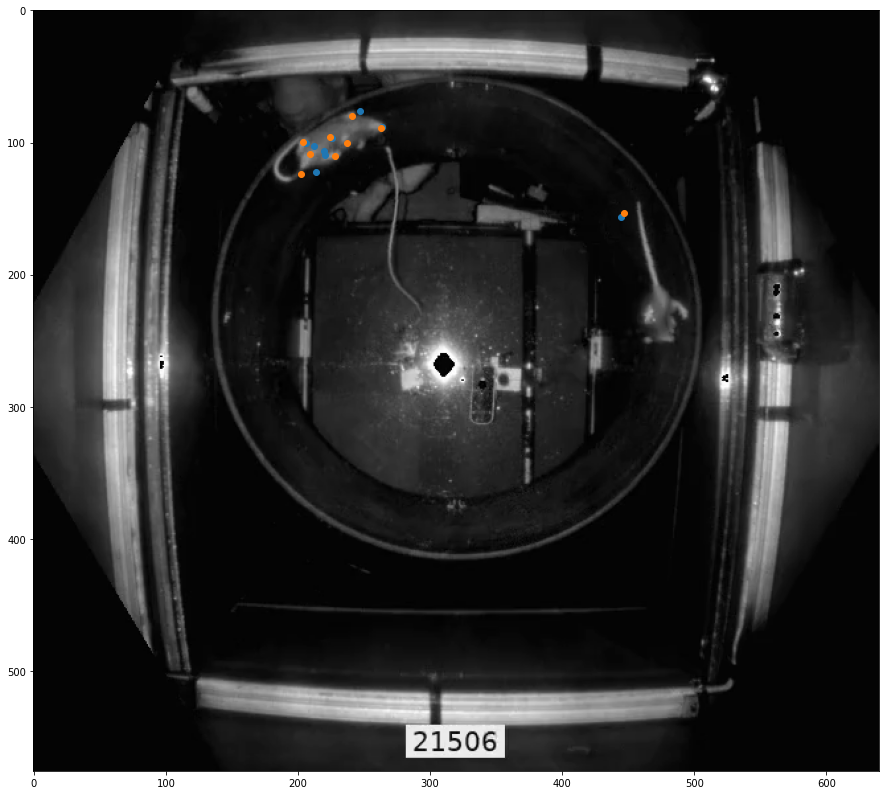

In [105]:
im = reader.get_data(ix+s)
plt.imshow(im)
plt.scatter(*yy.T)
plt.scatter(*pos[1][ix].T)
plt.gcf().set_size_inches((20,14))

In [ ]:
sqdev = ((observations-positions)**2).sum(-1)
norm = jnp.log(variance)/2*obs.shape[-1]
return -sqdev/2/variance-norm

In [83]:
outliers[-1][1][ix]

array([False, False, False, False, False, False, False, False, False])

In [87]:
outlier_probs[0,:,ix,:,0]

DeviceArray([[1.33989986e-03, 3.41666495e-04, 6.90239962e-04,
              7.14812683e-04, 2.31318633e-04, 4.23854639e-04,
              1.65325373e-02, 1.52338428e-02, 9.46236196e-04],
             [2.36770427e-03, 8.89223188e-04, 5.97462912e-04,
              2.06300071e-03, 1.94810447e-04, 3.08449137e-02,
              9.99726726e-01, 8.84837574e-02, 4.16296527e-01]],            dtype=float64)

In [86]:
outlier_probs = jnp.clip(jax.nn.sigmoid((.5-II.max(2))*20),1e-6,1-1e-6)


In [69]:
outlier_probs[0,:,ix,-1,0]

DeviceArray([2.55118409e-04, 9.99935796e-01], dtype=float64)

In [65]:
identity.max(2)[0,:,ix,-1,0]

DeviceArray([-0.69314718, -0.69314718], dtype=float64)